# CS421: Introduction to Machine Learning
## Project: Predicting Credit Card Customer Churn
### Model: Support Vector Machine
---

# 1. Importing packages & libraries

In [1]:
# import pyforest
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.svm import SVC

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

In [2]:
# train_df = pd.read_csv('../Data/train.csv')
# val_df = pd.read_csv('../Data/validation.csv')
# test_df = pd.read_csv('../Data/test.csv')
dataset_df = pd.read_csv('../Data/BankChurners.csv')

# 2. Reading file & tidying up columns

In [3]:
df = pd.read_csv('../Data/BankChurners.csv')
df = df.iloc[:,1:-2] # dropping first & last 2 columns 

tidied_cols = []
for col_name in df.columns:
    col_name = col_name.lower()
    if '_ct' in col_name:
        col_name = col_name.replace('_ct', '_count')
    if '_chng' in col_name:
        col_name = col_name.replace('_chng', '_change')
    tidied_cols.append( col_name )
    
df.columns = tidied_cols.copy()

df = df.drop(columns=["customer_age", "avg_open_to_buy", "total_trans_count"]) # dropping correlated features

# defining numerical & categorical columns
numerical = list(df.describe().columns)
categorical = [i for i in df.columns if i not in numerical and i != "attrition_flag"]


# 3. Train test split

In [4]:
y = df[["attrition_flag"]]
x = df.drop("attrition_flag", axis=1)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 2021)

### Impute unknown values in train & test sets

In [6]:
def impute_unknown(df_x):
    """
        Imputes unknown values to their mode
    """
    x = df_x.copy()

    marital_status_mode = x["marital_status"].mode()[0]
    x["marital_status"] = x["marital_status"].replace("Unknown", marital_status_mode)
    education_level_mode = x["education_level"].mode()[0]
    x["education_level"] = x["education_level"].replace("Unknown", education_level_mode)
    income_category_mode = x["income_category"].mode()[0]
    x["income_category"] = x["income_category"].replace("Unknown", income_category_mode)
    
    return x

x_train = impute_unknown(x_train)
x_test = impute_unknown(x_test)

# 4. Prepare for modelling

In [7]:
def data_preprocessing(df_x, df_y):
    x = df_x.copy()
    y = df_y.copy()
    
    # Binary Encoding — features with binary categories  
    attrition_mapper = {"Existing Customer":0, "Attrited Customer":1}
    y["attrition_flag"] = y["attrition_flag"].replace(attrition_mapper)
    
    gender_mapper = {"F":0, "M":1}
    x["gender"] = x["gender"].replace(gender_mapper)
    
    # Encoding features with multiple categories
    onehot_enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    values = onehot_enc.fit_transform(x[["marital_status"]])
    labels = np.array(["divorced", "married", "single"]).ravel()
    marital_status_df = pd.DataFrame(values, columns=labels)

    x.reset_index(drop=True, inplace=True)
    marital_status_df.reset_index(drop=True, inplace=True)
    x = pd.concat([x, marital_status_df], axis=1)
    x.drop("marital_status", axis=1, inplace=True)
    
    # Encoding Ordinal Features
    edu_level_mapper = {"Doctorate": 1, "Post-Graduate": 2, "Graduate": 3, "College": 4, "High School": 5, "Uneducated": 6}
    x["education_level"] = x["education_level"].replace(edu_level_mapper)

    income_cat_mapper = {"$120K +": 1, "$80K - $120K":2, "$60K - $80K":3, "$40K - $60K": 4, "Less than $40K": 5}
    x["income_category"] = x["income_category"].replace(income_cat_mapper)

    card_cat_mapper = {"Platinum":1, "Gold":2, "Silver":3, "Blue": 4}
    x["card_category"] = x["card_category"].replace(card_cat_mapper)
    
    # Feature Transformation — Scaling
    skewed = ["credit_limit", "total_amt_change_q4_q1", "total_trans_amt", "total_count_change_q4_q1"]

    for skewed_col in skewed:
#         x[skewed_col] = np.where(x[skewed_col] > 0 , np.log(x[skewed_col]), 0) # not using, leaving here for now
        x[skewed_col] = np.log(x[skewed_col].mask(x[skewed_col] <=0)).fillna(0)

    scaler = MinMaxScaler()
    x[numerical] = scaler.fit_transform(x[numerical]) 
    
    return x, y

x_train, y_train = data_preprocessing(x_train, y_train)
x_test, y_test = data_preprocessing(x_test, y_test)

# 5. Running SVM Model

In [8]:
# need to explore more on various SVM & hyperparameter tuning (WIP)
svm = SVC(random_state=0)
svm.fit(x_train, np.ravel(y_train))
y_pred = svm.predict(x_test)

# 6. Model Evaluation

In [9]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))

Testing accuracy 0.8568608094768015


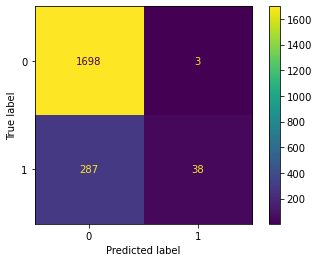

In [10]:
cm = confusion_matrix(y_test, y_pred, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = svm.classes_)
disp.plot()

In [11]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
print("AUC:", auc(false_positive_rate, true_positive_rate))
print("Accuracy:", accuracy_score(y_test, y_pred.round()))
print("Precision:", precision_score(y_test, y_pred.round()))
print("Recall:", recall_score(y_test, y_pred.round(), average='macro'))
print("f1_score:", f1_score(y_test, y_pred, average='macro'))

AUC: 0.5575797042463709
Accuracy: 0.8568608094768015
Precision: 0.926829268292683
Recall: 0.5575797042463709
f1_score: 0.5644871008008444


## PCA on Train Set

### Analysis of Explained Variance Ratio w.r.t Number of Components

In [29]:
pca_test = PCA(n)
pca_test.fit(x_train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df)

# decision boundary of at least 90% of cumulative explained variance
plt.axhline(color='r', y=0.9)

# ideal number of components -> 4 components 
plt.axvline(color='r', linewidth=4, linestyle='--', x=4)

,gender,dependent_count,education_level,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,total_amt_change_q4_q1,total_trans_amt,total_count_change_q4_q1,avg_utilization_ratio,divorced,married,single
0,0.291871,NaN,NaN,0.942512,NaN,NaN,NaN,NaN,NaN,0.114699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.995619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.715074,0.694804
3,NaN,NaN,NaN,NaN,0.469058,NaN,0.193917,NaN,NaN,0.318832,0.548450,NaN,NaN,NaN,0.565111,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,0.628409,NaN,0.228072,NaN,NaN,0.322881,0.615016,NaN,0.134106,NaN,0.212872,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,0.308778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.766975,0.368563,0.398411
